 # Image Caption Model

Algoritmul de descriere a imaginilor poate fi vazut ca o rețea de tipul encoder-decoder. Reteaua convolutionala codeaza imaginea intr-un format pe care reteaua recurenta il va putea folosi pentru a genera o descriere textuala.

#### Encoder
Vom folosi un model de VGG16 preantrenat pentru clasificarea imaginilor. Vom elimina unltimul layer de clasificare pentru a redirectiona iesirea stratului anterior. Stratul anterior are 4096 de neuroni, ale caror iesiri vor reprezenta un vector de 4096 de elemente ce descriu continutul imaginii. Acest vector va servi ca intrarea initiala a retelei neuronale recurente (Gated Recurrent Units sau GRU). Starea interna a retelei recurente are 512 elemente asa ca vectorul nostru va trebui redus la aceasta dimensiune cu ajutorul unui strat de 512 neuroni conectat complet la stratul anterior. 

#### Decoder
Decodorul foloseste starea initiala impreauna cu un marker de start "ssss" pentru a produce cuvintele ce descriu imaginea. In prima iteratie speram ca va da la iesire cuvantul "big". Imaginea este apoi servita din nou la intrarea retelei de data aceasta cu cuvintele obtinute in iteratiile anterioare pentru a putea obtine o propozitie. În final vom obține "big brown bear sitting eeee", unde "eeee" marchează finalul propozitiei.

O schemă a algoritmului arată in felul următor:

(de moficat aceasta poza)

![Flowchart](images/22_image_captioning_flowchart.png)

## Importuri

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop,Adam

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Am folosit Python 3.6 (Anaconda) and si urmatoarele versiuni de tensorflow si keras:

In [3]:
tf.__version__

'2.2.0'

In [4]:
tf.keras.__version__

'2.3.0-tf'

### Importul bazei de date

In [5]:
import coco

#### Descarcarea bazei de date

In [6]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


Obtinerea numelor imaginilor si a descrierilor din setul de antrenare

In [7]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


Numarul de imagini din setul de antrenare.


In [8]:
num_images_train = len(filenames_train)
num_images_train

118287

Obtinerea numelor fisierelor si a descrierilor pentru imaginile din setul de validare

In [74]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


In [75]:
num_images_val = len(filenames_val)
num_images_val

5000

### Functii ajutatoare

Incarcarea si redimensionarea imaginilor

In [10]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

Afisarea imaginii si descrierilor aferente

In [11]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example



A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


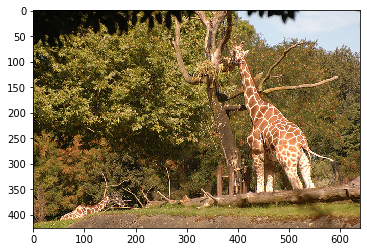

A motorcycle parked in a parking space next to another motorcycle.
An old motorcycle parked beside other motorcycles with a brown leather seat.
Motorcycle parked in the parking lot of asphalt.
A close up view of a motorized bicycle, sitting in a rack. 
The back tire of an old style motorcycle is resting in a metal stand. 


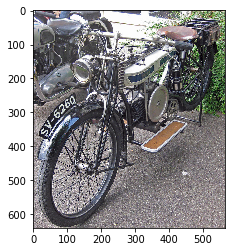

A person doing karate in a field at night
A man standing on a lush green field holding a Frisbee.
A man throwing a frisbee in a dark field.
A man raring back with a frisbee in his hand while on a darkened field.
A man standing outside on the grass at night making body motions.


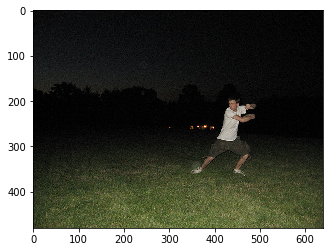

In [12]:
show_image(idx=1, train=True)
show_image(idx=11, train=True)
show_image(idx=111, train=True)

## Pre-Trained Image Model (VGG16)

Vom crea o instanta de VGG16 folosind API-ul de Keras. Modelul a fost deja preantrenat pe setul de date ImageNet. VGG16 contine un segment de straturi convolutionale urmata de staturi fully-connected, folosite pentru clasificarea imaginilor.

`include_top=True` va descarca intreaga retea ce are 528 de MB. Avem nevoie de intreaga retea deoarce vom folosi si o parte din straturile interconectate pentru descrierea imaginilor.



In [13]:
image_model = VGG16(include_top=True, weights='imagenet')

Print a list of all the layers in the VGG16 model.

In [14]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Folosim penultimul layer de clasificare, numit `fc2`. Acesta e un strat dens/complet conecatat.

In [15]:
transfer_layer = image_model.get_layer('fc2')

Il numim "transfer-layer" deoarece va transfera informatiile venite de la reteaua convolutionala.

Cream un nou model ce are aceeasi intrare ca reteaua de mai sus insă iesirea este penultimul strat

In [16]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

Modelul se asteapta ca imaginile sa aiba urmatoarea dimensiune

In [17]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

Pentru fiecare imagine modelul va obtine un vector de 4096 valori

In [18]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Procesarea tuturor imaginilor

Vom crea functii ce au rol sa preproceseze imaginile din seturile de date folosind modelul preantrenat si salvand valorile intr-un fisier pentru a putea fi reincarcate rapid.

Obtinem astfel un nou set de date de intrare cu valorile preprocesate. Nu vom schimba toți parametrii modelului VGG16. Avem nevoie de valorile de transfer pentru a instrui modelul de subtitrare a imaginii pentru mai multe epoci, astfel încât economisim mult timp calculând valorile de transfer o dată și salvându-le într-un fișier *.pkl in prealabil.

Aceasta este o funcție de ajutor pentru afisarea progresului.

In [19]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()


Aceasta este funcția pentru procesarea fișierelor date folosind modelul VGG16 și returnarea valorilor de transfer ale acestora.

In [20]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Procesarea imagnilor de antrenare

In [21]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

Procesarea imagnilor de validare

In [22]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

Procesam toate imaginile din setul de antrenament și le salvam valorile de transfer într-un fișier cache. Acest proces a durat aproximativ 90 de minute pentru o GPU 1060 GTX.

In [23]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 1.42 s


Procesam toate imaginile din setul de validare și le salvam valorile de transfer într-un fișier cache. Acest proces a durat aproximativ 10 minute pentru un GPU 1060 GTX.

In [24]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 61 ms


## Tokenizer

Retelele neuronale nu pot lucra direct pe cuvinte. Pentru a putea obtine o descriere textuala vom folosi un procedeu denumit tokenizare. Vom desemna un vocabular de 10000 de cuvinte si fiecarui cuvant ii vom atribui un numar intreg. Inceputul si finalul propozitiei vor fi formate din 2 cuvinte care sunt putin probabile sa faca parte din setul de antrenare.



In [25]:
mark_start = 'ssss '
mark_end = ' eeee'

Functia va adauga markerul de inceput si final capturilor din setul de antrenare si verificare

In [26]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [27]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [28]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

Transformam setul de antrenare intr-un vector de numere intregi

In [29]:
captions_train_flat = flatten(captions_train_marked)

Setam numarul maxim de cuvinte distincte cu care vom antrena.

In [30]:
num_words = 10000

Un wrapper asupra functiei de tokenizare deja existenta in Keras

In [31]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Cream o instanta a clasei

In [32]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 8.5 s


Obtinem indexul markerului de start('ssss').

In [33]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

Obtinem indexul markerului de final('eeee').

In [34]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [35]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 8.43 s


Cuvintele convertite in numere intregi

In [36]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

Propozitiile corespondente

In [37]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

## Generatorul de date

Fiecare imagine are cel putin 5 descrieri ale continutului. Reteaua neuronala va fi antrenata cu batch-uri ale valorilor intermediare venite de la vgg16 si o secvente de numere intregi reprezentand descrierea lor. Dacă ar trebui să avem matricile de numpy potrivite pentru setul de antrenament (adica ce obtinem la intrarea retelei recurente cu cele cel putin 5 descrieri valide), fie ar trebui să folosim o singură legendă pentru fiecare imagine și să ignorăm restul acestor date valoroase, fie ar trebui să repetăm valorile de transfer de imagine pentru fiecare dintre legendele, care ar irosi multă memorie.

O soluție mai bună este crearea unui generator de date personalizat pentru Keras care va crea un lot de date cu valori de transfer selectate aleatoriu și secvențe de simboluri.

Această funcție returnează o listă de secvențe ale tokenizer-ului aleatoriu pentru imagini cu indicii date în setul de antrenament.


In [38]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

This generator function creates random batches of training-data for use in training the neural network.

In [39]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

### Pasi per epoca

Dat fiind modul de generare al datelor putem intalni cazuri in care in aceeasi epoca se repeta o imagine de mai multe ori cu descrieri diferite, sau o imagine nu este utilizata deloc. Vom folosi totusi termenul de epoca pentru a masura timpul de antrenament al modelului

In [40]:
num_captions_train = [len(captions) for captions in captions_train]

Numarul total de descrieri din setul de antrenare

In [41]:
total_num_captions_train = np.sum(num_captions_train)

## Crearea Retelei Recurente

Vom crea o retea recurenta ce va primi la intrare valorile de transfer de la reteaua convolutionala ce are ca scop sa determine obiectele din imagine, cat si propozitia construita deja pentru a genera o descriere textuala a imaginii de la intrare. Aceasta retea este decoder-ul arhitecturii noastre.

Acest model va fi insa detasat de primul model. El va fi compilat si antrenat separat. Acesta este alcatuit din 3 straturi de 

Gated Recurent Units a caror stare interna este:

In [42]:
state_size = 512

Stratul de embedding converteste valorile intregi de la intrare in vectori de lungimea:

In [43]:
embedding_size = 128

Valorile de intrare pentru decoder

In [44]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

La iesirea penultimului strat din VGG16 avem 4096 valori dar GRU-ul nostru are doar 512 stari interne. Vom reduce numarul de valori cu ajutorul unui strat dens intermediar de 512 neuroni ce va preceda arhitectura recurenta.

Folosim functia de activare `tanh` pentru a avea valori cuprinse intre -1 si 1.

In [45]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

Intrarea in acest decoder poate avea lungimi arbitrare

In [46]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [47]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')


Cream secventa de straturi recurente.

In [48]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

La iesire vom avea un vector de forma `[batch_size, sequence_length, state_size]`. Fiecare cuvant ce va alcatui descrierea va veni sub forma unui vector(format din activarile lui GRU3). Aceste secvente trebuie convertite in numere intregi pentru a putea obtine din maparea numar-cuvant anterior definita, o propozitie.

Aceasta mapare se va face cu ajutorul unui strat de iesire ce va avea numarul de neuroni egal cu numarul vocabularului nostru


In [49]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Conectarea intrarii si crearea modelului de antrenare

Conectarea retelei recurente la encoder ul nostru(VGG16)

In [50]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [51]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

### Compilarea modelului

Stratul de iesire va fi reprezentat de un set de neuroni peste care se va aplica o decodare de tipul 'one-hot'. Cu toate aceastea validarea contine un set de valori tokenizate. Ca functie loss, vom utiliza sparse cross-entropy ce face o conversie interna intre o valoare intreaga si un vector cu codare one hot pentru fiecare cuvant.

Am testat aici atat cu Adam optimizer cat si cu RMSprop si am ajuns la concluzia ca cel din urma are perfomantele cele mai mari. Adam functioneaza bine in primele epoci insa esueaza in a face o convergenta dupa ceva vreme.



In [52]:
decoder_model.compile(optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False),
                      loss='sparse_categorical_crossentropy')

### Callback Functions


In [53]:
path_checkpoint = 'captionThisModel.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

Log-uri de TensorBoard(Inca nu m-am uitat peste ele). Pot fi utile in lucrarea teoretica

In [54]:
callback_tensorboard = TensorBoard(log_dir='./captionThis_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [55]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

Incarcarea ultimului model.

In [56]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model

Vom antrena modelul decoder-ului.

O epoca a durat 4-5 ore pe un GTX 1060 GPU, 6GB cu un batch size de 3000. 



In [57]:
batch_size = 3000
generator = batch_generator(batch_size=batch_size)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

197

In [141]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=10,
                  callbacks=callbacks)

Epoch 1/10
295/295 [==============================] - ETA: 0s - loss: 0.6806 
Epoch 00001: saving model to captionThisModel.h5
295/295 [==============================] - 17519s 59s/step - loss: 0.6806
Epoch 2/10
295/295 [==============================] - ETA: 0s - loss: 0.6770  
Epoch 00002: saving model to captionThisModel.h5
295/295 [==============================] - 18075s 61s/step - loss: 0.6770
Epoch 3/10
295/295 [==============================] - ETA: 0s - loss: 0.6564  
Epoch 00003: saving model to captionThisModel.h5
295/295 [==============================] - 17881s 61s/step - loss: 0.6564
Epoch 4/10
295/295 [==============================] - ETA: 0s - loss: 0.6512  
Epoch 00004: saving model to captionThisModel.h5
295/295 [==============================] - 19080s 65s/step - loss: 0.6512
Epoch 5/10
295/295 [==============================] - ETA: 0s - loss: 0.6546  
Epoch 00005: saving model to captionThisModel.h5
295/295 [==============================] - 18077s 61s/step - loss

## Generarea descrierilor

Functia incarca o imagine si genereaza o descriere

In [191]:
def generate_caption(image_path, max_tokens=30, plot=True, printc=True):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input
    
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        
        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    if plot:
        # Plot the image.
        plt.imshow(image)
        plt.show()
    output_text=output_text[1].upper()+output_text[2:-5]+'.'
    
    if printc== True:
        # Print the predicted caption.
        print("Predicted caption:")
        print(output_text)
        print()
    return output_text

### Example

O poza cu 2 pasari

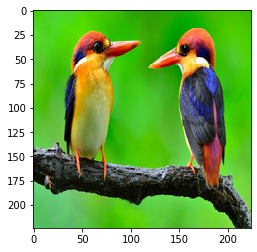

Predicted caption:
A bird is sitting on a branch of a tree.



'A bird is sitting on a branch of a tree.'

In [192]:
generate_caption("test/birds.jpg")

O poza cu un atlet

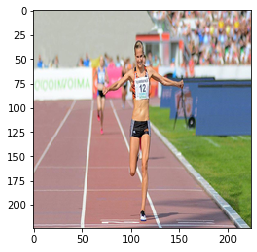

Predicted caption:
A baseball player is up to bat at a game.



'A baseball player is up to bat at a game.'

In [193]:
generate_caption("test/athlete.jpg")

O poza cu un urs

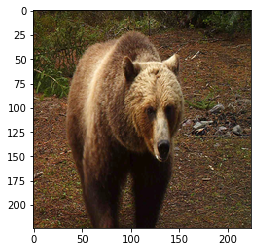

Predicted caption:
A bear is standing on a rocky surface.



'A bear is standing on a rocky surface.'

In [194]:
generate_caption("test/bear.jpg")

O poza cu o plaja

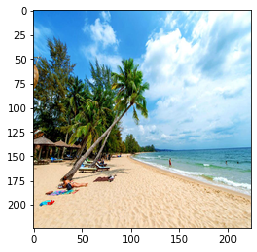

Predicted caption:
A person on a beach flying a kite.



'A person on a beach flying a kite.'

In [195]:
generate_caption("test/beach.jpg") 

O poza cu o masina

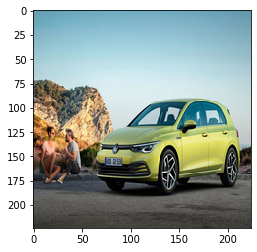

Predicted caption:
A car parked on the side of a road with a truck behind it.



'A car parked on the side of a road with a truck behind it.'

In [196]:
generate_caption("test/golf.jpg") 

O poza cu un om

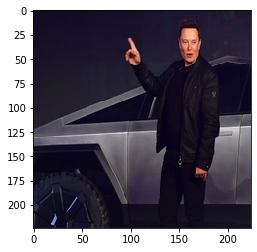

Predicted caption:
A man is standing in front of a mirror.



'A man is standing in front of a mirror.'

In [197]:
generate_caption("test/musk.jpeg") 

O poza cu o femeie si un obiect

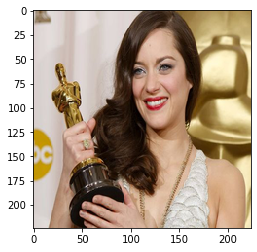

Predicted caption:
A young child is brushing his teeth with a toothbrush.



'A young child is brushing his teeth with a toothbrush.'

In [198]:
generate_caption("test/marion.jpg") 

O poza doar cu o femeie

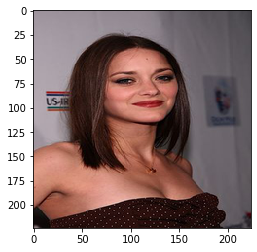

Predicted caption:
A woman with a cell phone in her hand.



'A woman with a cell phone in her hand.'

In [199]:
generate_caption("test/marion1.jpg") 

Sa incercam cu poza unei capre

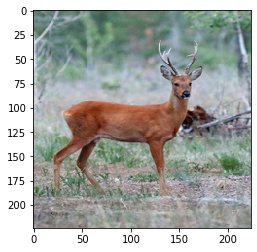

Predicted caption:
A giraffe standing in a field with a tree in the background.



'A giraffe standing in a field with a tree in the background.'

In [200]:
generate_caption("test/deer.jpg") 

Urmeaza sa definim o functie care sa ne afiseze o imagine din setul de antrenare/validare si rezultatul pe care il produce modelul nostru.

In [201]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

Alta imagine din setul de antrenare

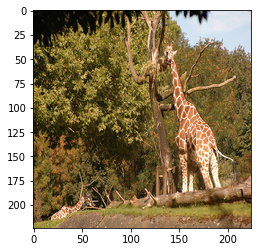

Predicted caption:
A giraffe standing in a field of grass.

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [202]:
generate_caption_coco(idx=1, train=True)

Alta imagine din setul de validare

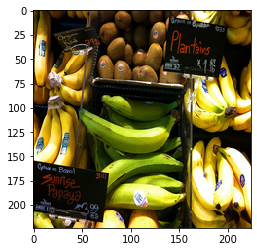

Predicted caption:
A table topped with plates of food and a cup of coffee.

True captions:
A store display filled with ripe, unripe bananas and other fruit.
A group of bananas surround a small display of kiwi.
A fruit stand with plantains, kiwis, and bananas. 
A fruit stand that has bananas, papaya, and plantains.  
A fruit stand display with bananas and kiwi


In [203]:
generate_caption_coco(idx=4999, train=False)

# Metrica de acuratețe

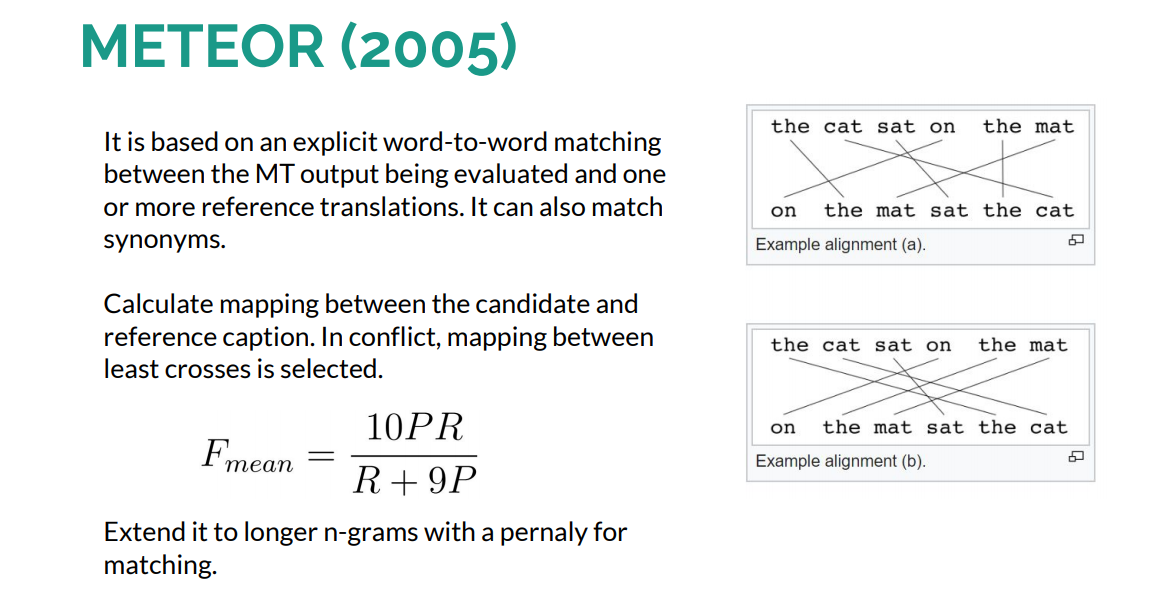

In [204]:
import nltk
nltk.data.path=[r'C:\Users\George\Desktop\Dizertatie\Python']
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [220]:
def MeteorScore():
    data_dir = coco.val_dir
    acc=0
    for idx in range(num_images_val):
        filename = filenames_val[idx]
        caption_val_set = captions_val[idx]
        path=os.path.join(data_dir, filename)
        caption=generate_caption(image_path=path,plot=False,printc=False)
        acc+=round(nltk.meteor(caption_val_set, caption),4)
    return acc/num_images_val

In [212]:
print('METEOR score is {}'.format(round(MeteorScore(),4)))

METEOR score is 0.3408


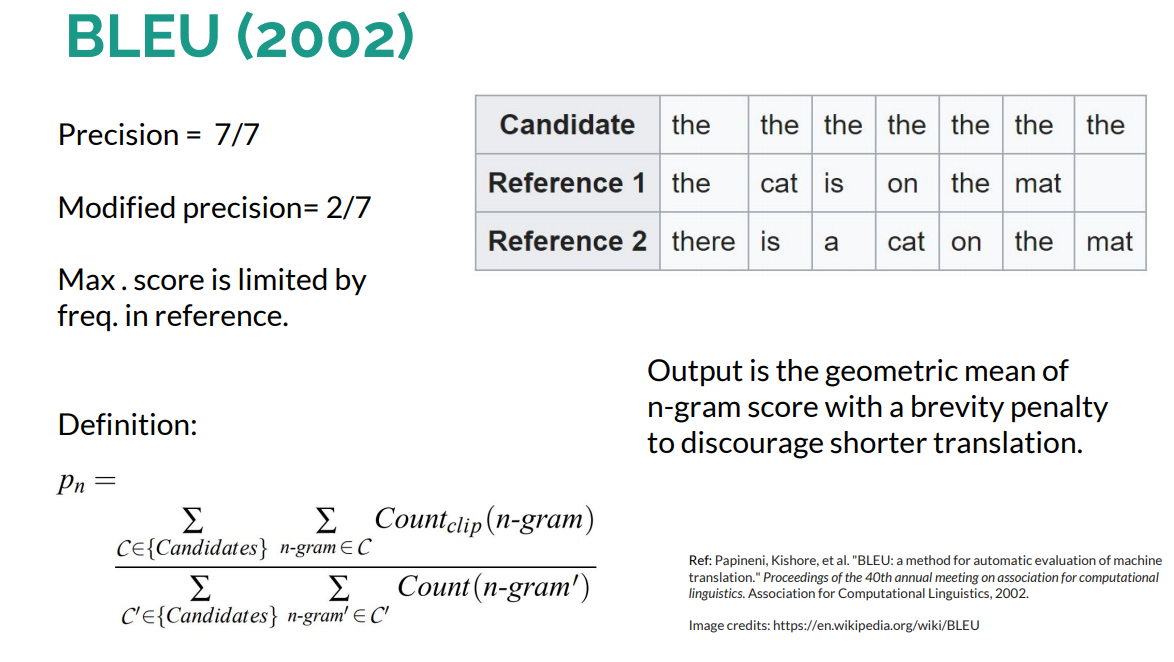

In [ ]:
import nltk.translate.bleu_score as bleu

In [213]:
def BleuScore():
    data_dir = coco.val_dir
    acc=0
    for idx in range(num_images_val):
        filename = filenames_val[idx]
        caption_val_set = captions_val[idx]
        path=os.path.join(data_dir, filename)
        caption=generate_caption(image_path=path,plot=False,printc=False)
        acc+=round(bleu.sentence_bleu(caption_val_set, caption),4)
    return acc/num_images_val

In [218]:
print('BLEU score is {}'.format(round(BleuScore(),4)))

BLEU score is 0.3408


Salvam Modelul

In [76]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 4096)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
____________________________________________________________________________________________

In [77]:
decoder_model.save(r'C:\Users\George\Desktop\Dizertatie\Python\Caption Model\finalModel')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\George\Desktop\Dizertatie\Python\Caption Model\finalModel\assets


Verificam ca modelul se incă

In [78]:
newModel=tf.keras.models.load_model('finalModel')
newModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay [(None, 4096)]       0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 128)    1280000     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
____________________________________________________________________________________________

## Sfarsit/Concluzii